# Machine Learning Demonstrations - 4


To run these notebooks, you need to install python dependencies:

Install tensorflow:

With conda:

```conda install -c anaconda tensorflow-gpu```

With pip:

```pip install tensorflow-gpu```

Other dependencies:

With pip:

```pip install Keras==2.0.9
pip install numpy==1.14.0
pip install matplotlib==2.0.2
pip install scikit_learn==0.19.1```


## Feature Engineering

Feature engineering is the process of modifying input features to make machine learning algorithms work more effectively.
Manual feature engineering requires both
- knowledge of the chosen algorithm
- domain knowledge of the dataset

### Normalization

Certain machine learning algorithms (e.g. k-Nearest Neighbours) require the calculation of a distance between points in the feature space.  
The features must, therefore, all be on the same scale. Otherwise, the feature with the most magnified scale will get the highest weighting.

The process of scaling features is called *Normalization*.

A number of algorithms different are available within scikit-learn.

The [Standard Scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) scales the data via a linear transformation that transforms the mean value of each feature to 0 and the standard deviation of each feature to 1. This has the advantage of being simple, fast and easily explainable. However, it is not robust to outliers.

The [MinMax Scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) scales the data via a linear transformation that transforms the minimum and maximum values of each feature to [0,1]. Again, this is simple, fast and easily understood, but not robust to outliers.

The [Robust Scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler) scales the data via a linear transformation that transforms the interquartile range of each feature to [-1,1]. This scaler *is* robust to the presence of outliers, as they will lie outside the interquartile range. However, the outliers will continue to lie away from the majority of points, and can therefore have an outsize impact on predictions. 

The [Quantiles Transformer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer) converts the distribution of each feature to a standard normal distribution. This is *not* a linear transformation, but a transformation based on the distribution of the inputs. This transformation is *very* sensitive to outliers, but the distribution of the scalar's output is always the same.  
This method would be most relevant where the levels of a feature were basically meaningless, but the rank ordering of the feature was important.

We can look at the effect of the 4 different normalizers on random data generated from four different distributions
- Normal
- Uniform
- Gamma
- Student-T
- Mixture of Gaussians

Looking at the normalized distributions, we see that the effect of normalization can be quite different, depending on the distribution of the unscaled data.  
e.g. Even after applying the Standard Scaler, data drawn from *fat-tailed* distributions still have values that are an order-of-magnitude larger than others. 

<img src="../images/scalers.png" />


We will examine the impact of scaling algorithms on a k-NN classification model, applied to the Wisconsin Breast Cancer dataset. We will split the data evenly into training and test datasets.

In [1]:
/ Utility functions
\l ../utils/funcs.q
\l ../utils/graphics.q

In [2]:
data:.p.import[`sklearn.datasets;`:load_breast_cancer][]
features:data[`:data]`
target:data[`:target]`
datadict:traintestsplit[features;target;0.5]
/ Inspect data
-1"Shape of features is ",sv[" x "]string shape features;
-1"";show 5#features;-1"";
-1"Distribution of target values is:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target);
-1"\nTraining/test split is:\n";
show count each datadict:traintestsplit[features;target;.5]

Shape of features is 569 x 30

17.99 10.38 122.8 1001  0.1184  0.2776  0.3001 0.1471  0.2419 0.07871 1.095  ..
20.57 17.77 132.9 1326  0.08474 0.07864 0.0869 0.07017 0.1812 0.05667 0.5435 ..
19.69 21.25 130   1203  0.1096  0.1599  0.1974 0.1279  0.2069 0.05999 0.7456 ..
11.42 20.38 77.58 386.1 0.1425  0.2839  0.2414 0.1052  0.2597 0.09744 0.4956 ..
20.29 14.34 135.1 1297  0.1003  0.1328  0.198  0.1043  0.1809 0.05883 0.7572 ..

Distribution of target values is:

target| num pcnt 
------| ---------
0     | 212 37.26
1     | 357 62.74

Training/test split is:

xtrain| 284
ytrain| 284
xtest | 285
ytest | 285


We have deliberately retained a large proportion (50%) of our data for final testing, so that the accuracy rates reflect performance on a significant amount of 'previously unseen' data.

In [3]:
standard:.p.import[`sklearn.preprocessing]`:StandardScaler;
minmax:  .p.import[`sklearn.preprocessing]`:MinMaxScaler;
robust:  .p.import[`sklearn.preprocessing]`:RobustScaler;
quantile:.p.import[`sklearn.preprocessing]`:QuantileTransformer;

knclassifier:.p.import[`sklearn.neighbors]`:KNeighborsClassifier;

preprocessors:standard[],minmax[],robust[],quantile[];
names:`Standard`MinMax`Robust`Quantiles;

maxk:200
accs:((count preprocessors),maxk)#`float$0

colors:`r`g`b`y`k
Crossval:{[i;prepro;k]
  classifier:knclassifier[k];
  classifier[`:fit][prepro[`:transform][datadict.xtest];datadict.ytest];
  preds:classifier[`:predict;<][prepro[`:transform]datadict.xtest];
  accs[i;k-1]::accuracy[datadict.ytest;preds];
 }
Results:{[i;prepro;names;k]
  preprocessor:prepro[i][`:fit]datadict.xtrain;
  Crossval[i;preprocessor;]each 1+til k;
  ax[`:plot][til k;accs[i];colors[i];`label pykw names[i]];
 }

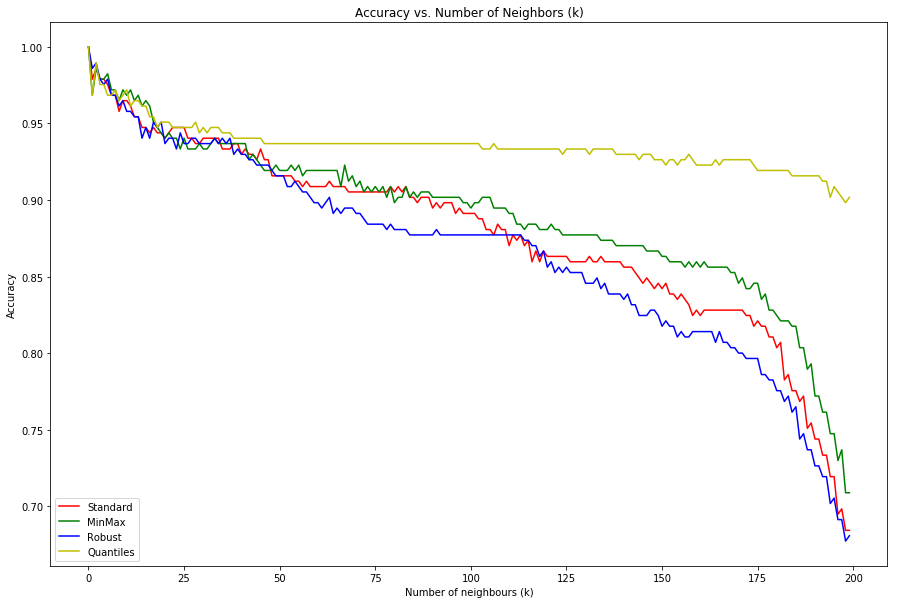

In [4]:
// Initialize the plot
plot:plt[`:subplots][];
fig:plot[@;0];
ax:plot[@;1];
// Obtain results
Results[;preprocessors;names;maxk]each til count preprocessors;
// Customize the plot
fig[`:set_figheight]10;
fig[`:set_figwidth]15;
plt[`:xlabel]"Number of neighbours (k)";
plt[`:ylabel]"Accuracy";
plt[`:title ]"Accuracy vs. Number of Neighbors (k)";
plt[`:legend][`loc pykw"lower left"];
plt[`:show][];

The different scalers perform comparably for the optimal values.  However, the Quantiles tranformer proves considerably more robust as k increases. This suggests that, at least for a subset of the feature variables, ordering is more important than actual feature value.

### One Hot Encoding
One hot encoding is a method of encoding categorical variables to be more appropriate for machine learning algorithms.

We assign an integer index to each distinct category, and represent each value with a vector of **0**s and **1**s.  
The vector has length equal to the number of distinct categories, with a **0** in every position except the relevant category index (given value **1**).

Consider categorical data drawn uniformly from 3 classes

In [5]:
show data:10?`AAA`BBB`CCC;

`AAA`AAA`BBB`BBB`AAA`AAA`AAA`BBB`AAA`CCC


We use one hot encoding to replace each point with a vector (of length 3), with a **1** indicating the original category.

In [6]:
show onehot data;

1 0 0
1 0 0
0 1 0
0 1 0
1 0 0
1 0 0
1 0 0
0 1 0
1 0 0
0 0 1


Why do we do this? Why not simply enumerate the classes and use the resulting integer labels?  
The problem is that numerical values will be interpreted by the model as having an order.  

This may be ok if the category in question is ordinal
```
Small (0)
Medium (1)
Large (2)
```

But it is bound to cause problems when there is no intrinsic ordering
```
London (0)
Paris (1)
New York (2)
```

Given this encoding, a machine learning algorithm may assume an ordering that is not there.  
e.g. It could act as if Paris is, in some way, *between* London and New York.

We will investigate the impact of using one-hot encoding (versus a basic enumeration) using a Neural Network applied to the MNIST dataset.

In [7]:
mnist:.p.import[`keras.datasets.mnist][`:load_data;<][]
data:raze(`xtrain`ytrain;`xtest`ytest)!'mnist
@[`data;`xtrain`xtest;%;255];
@[`data;`ytrain`ytest;"f"$];
/ Inspect data
-1 string[count data`xtrain]," samples of shape ",sv[" x "]string 1_shape data`xtrain;
-1"";show 5#data`xtrain;-1"";
-1"Distribution of target values is:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target:data`ytrain);
-1"\nTraining/test split is:\n";
show count each data;

/home/fionnuala/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/fionnuala/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2018-04-26 11:06:09.973205: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-04-26 11:06:10.077105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-04-26 11:06

60000 samples of shape 28 x 28

0 0 0 0 0         0         0          0          0          0          0    ..
0 0 0 0 0 0 0         0          0         0          0         0          0 ..
0 0 0 0         0         0         0         0         0         0         0..
0 0 0 0 0 0 0 0 0          0         0         0         0         0         ..
0 0 0 0 0 0 0          0         0         0          0          0          0..

Distribution of target values is:

target| num  pcnt 
------| ----------
0     | 5923 9.87 
1     | 6742 11.24
2     | 5958 9.93 
3     | 6131 10.22
4     | 5842 9.74 
5     | 5421 9.04 
6     | 5918 9.86 
7     | 6265 10.44
8     | 5851 9.75 
9     | 5949 9.92 

Training/test split is:

xtrain| 60000
ytrain| 60000
xtest | 10000
ytest | 10000


In [8]:
@[`data;`otrain`otest;:;onehot each data`ytrain`ytest];
/ Function to prepare images
prepImg:{nparray[(raze/)x][`:reshape]count[x],28 28 1}
/ Function to prepare mnist data
prepMnist:{[data;ignore;invert]
  idx:where each$[invert;;not]data[`ytrain`ytest]in\:raze ignore;
  data:@[;;@;]/[data;`xtrain`xtest`ytrain`ytest`otrain`otest;6#idx];
  @[;`xtrain`xtest;prepImg]@[;`ytrain`ytest`otrain`otest;nparray]data
 }

Define separate Neural Networks to train on
- Continuous labels
- One-hot encoded labels

In [9]:
/ Keras building blocks of model
conv2d:      .p.import[`keras.layers]`:Conv2D;
maxpooling2d:.p.import[`keras.layers]`:MaxPooling2D;
dense:       .p.import[`keras.layers]`:Dense;
dropout:     .p.import[`keras.layers]`:Dropout;
flatten:     .p.import[`keras.layers]`:Flatten;
sequential:  .p.import[`keras.models]`:Sequential;
callback:    .p.import[`keras.callbacks]`:Callback;
adadelta:    .p.import[`keras.optimizers]`:Adadelta;

In [10]:
/ Function to create a continuous-valued model
continuousmodel:{
  model:sequential[];
  model[`:add]conv2d[32;`kernel_size pykw 3 3;`activation pykw`relu;`input_shape pykw 28 28 1];
  model[`:add]conv2d[64;`kernel_size pykw 3 3;`activation pykw`relu];
  model[`:add]maxpooling2d[`pool_size pykw 2 2];
  model[`:add]flatten[];
  model[`:add]dense[128;`activation pykw`relu];
  model[`:add]dense[1;`activation pykw`relu];
  model[`:compile][`loss pykw`mean_squared_error;`optimizer pykw adadelta[];`metrics pykw pylist enlist`accuracy];
  model}
continuousmodel[][`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,198,721
Trainable params: 1,198,721
Non-trainable params: 0
_________________________________________________________________


In [11]:
/ Function to create a one-hot encoding model
onehotmodel:{
  model:sequential[];
  model[`:add][conv2d[32;`kernel_size pykw 3 3;`activation pykw`relu;`input_shape pykw 28 28 1]];
  model[`:add][conv2d[64;`kernel_size pykw 3 3;`activation pykw`relu]];
  model[`:add]maxpooling2d `pool_size pykw 2 2;
  model[`:add]dropout 0.25;
  model[`:add]flatten[];
  model[`:add]dense[128;`activation pykw`relu];
  model[`:add]dropout 0.5;
  model[`:add]dense[10;`activation pykw`softmax];
  model[`:compile][`loss pykw `categorical_crossentropy;`optimizer pykw adadelta[];`metrics pykw pylist enlist `accuracy];
  model}
onehotmodel[][`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

Fit models, with data encoded as appropriate

In [12]:
epochs:20
batchsz:128
alldata:prepMnist[data;();0b]

In [13]:
/ Fit continuous model
cmodel:continuousmodel[];
start:.z.T
cresults:cmodel[`:fit][alldata`xtrain;alldata`ytrain;`batch_size pykw batchsz;`verbose pykw 3;`epochs pykw epochs;`validation_data pykw(alldata[`xtest]`.;alldata[`ytest]`.)]
-1"Training continuous model for ",string[epochs]," epochs took ",string .z.T-start;

Train on 60000 samples, validate on 10000 samples
Epoch 1/20


2018-04-26 11:06:25.833983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1120] Creating TensorFlow device (/device:GPU:0) -> (device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Training continuous model for 20 epochs took 00:01:28.018


In [14]:
/ Fit one-hot model
omodel:onehotmodel[];
start:.z.T
oresults:omodel[`:fit][alldata`xtrain;alldata`otrain;`batch_size pykw batchsz;`verbose pykw 3;`epochs pykw epochs;`validation_data pykw(alldata[`xtest]`.;alldata[`otest]`.)]
-1"Training one-hot model for ",string[epochs]," epochs took ",string .z.T-start;

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Training one-hot model for 20 epochs took 00:01:36.322


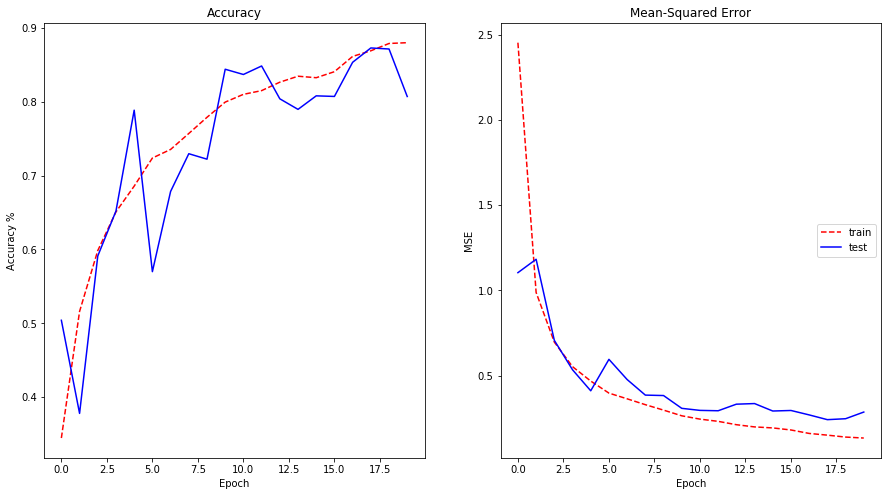

In [15]:
/ Performance of continuous model
history:cresults[`:history]`
plotAccMSE . history`acc`val_acc`loss`val_loss;

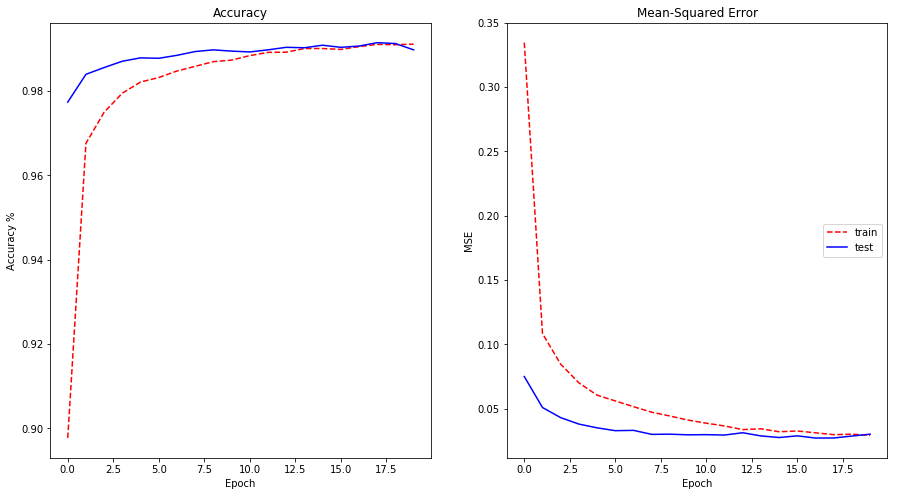

In [16]:
/ Performance of one-hot model
history:oresults[`:history]`
plotAccMSE . history`acc`val_acc`loss`val_loss;

The continuous-valued model achieves 86% accuracy after 20 epochs, with performance fairly erratic across successive epochs. 

In comparison, the model with one-hot encoding provides *smoother* prediction accuracy. It also achieves an accuracy over 90% accuracy after just 1 epoch, increasing to 99% after just a few epochs.  
A technical explanation, is that one-hot coding allows the backpropagation algorithm to provide *separate* training signals for each image class.

Training with one-hot labels therefore seems considerably faster and, ultimately, more successful.